In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.integrate

# Comparisons

To make things really easy, let's ignore time, and work in one dimension.  Events will take place in $[0,1]$.

## Example 1

Actual pattern is [CSR](https://en.wikipedia.org/wiki/Complete_spatial_randomness) with some overall rate (say 10 events, on average).  One "prediction" is the same, other other is a inhomogeneous Poisson process with intensity $2t$ for $0\leq t\leq 1$.

## Hit rate

We put a grid down (chunk $[0,1]$ into intervals), select 5% (or whatever) of the intervals by risk, and see how many events we capture.  If grid cells have the same risk, we'll break at random.

We cannot tell the difference (as should be).

In [2]:
def coverage1(total_cells, cells_to_pick):
    # Homogeneous, so pick at random
    return np.random.choice(total_cells, size=cells_to_pick, replace=False)
    
def coverage2(total_cells, cells_to_pick):
    # Intensity increases, so top slice will always pick the last cells
    return np.arange(total_cells)[-cells_to_pick:]

assert np.all(coverage2(10, 3) == [7,8,9])

def score(events, total_cells, cells):
    count = 0
    for t in events:
        t = int(np.floor(t * total_cells))
        if t in cells:
            count += 1
    return count / len(events)

In [3]:
trials = 10000
cells = 10
coverage = 3

hit_rate_1 = []
hit_rate_2 = []
for _ in range(trials):
    num_events = np.random.poisson(lam=10)
    events = np.random.random(size=num_events)
    if len(events) == 0:
        continue
    pred1 = coverage1(cells, coverage)
    pred2 = coverage2(cells, coverage)
    hit_rate_1.append( score(events, cells, pred1) )
    hit_rate_2.append( score(events, cells, pred2) )

In [4]:
pd.DataFrame({"One":hit_rate_1, "Two":hit_rate_2}).describe()

,One,Two
count,10000.000000,10000.000000
mean,0.302664,0.299560
std,0.155089,0.156065
min,0.000000,0.000000
25%,0.200000,0.200000
50%,0.300000,0.285714
75%,0.400000,0.400000
max,1.000000,1.000000


## Likelihood

For each prediction, compute the likelihood of the events, the product of density function evaluated at each point.  As ever, we really work with log likelihood, to avoid numerical errors.  We can then:

- Compute the likelihood ratio, to see which prediction is closer.  This strongly favours model 1.
- Normalise to give some absolute likelihood.  Model 1 again is favoured.

In [5]:
def likelihood1(events):
    return 0

def likelihood2(events):
    return np.sum(np.log(np.asarray(events) * 2))

In [6]:
ratios = []

for _ in range(10000):
    num_events = np.random.poisson(lam=10)
    events = np.random.random(size=num_events)
    log_ratio = likelihood1(events) - likelihood2(events)
    ratios.append(log_ratio)

In [7]:
pd.DataFrame(ratios).describe()

,0
count,10000.000000
mean,3.063269
std,3.319015
min,-4.781459
25%,0.640241
50%,2.633811
75%,4.994303
max,20.325528


In [8]:
one, two = [], []
for _ in range(10000):
    num_events = np.random.poisson(lam=10)
    events = np.random.random(size=num_events)
    if len(events) == 0:
        continue
    one.append( likelihood1(events) / len(events) )
    two.append( likelihood2(events) / len(events) )

In [9]:
pd.DataFrame({"one":one, "two":two}).describe()

,one,two
count,10000.0,10000.000000
mean,0.0,-0.302210
std,0.0,0.334594
min,0.0,-2.553526
25%,0.0,-0.492402
50%,0.0,-0.268450
75%,0.0,-0.069880
max,0.0,0.670229


## KDE and mean squared error

Use the events and KDE to estimate a "real" density, and compare this with the model by integrating the error.

This again favours model 1 (smaller average error).

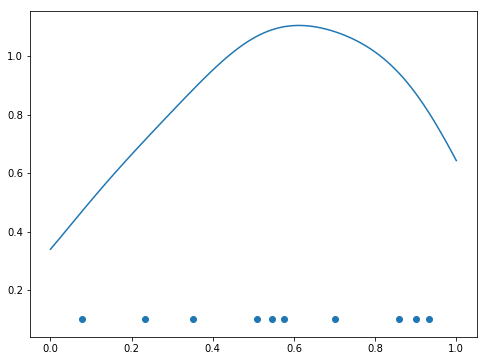

In [10]:
events = np.random.random(size=10)
kernel = scipy.stats.kde.gaussian_kde(events)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(events, [0.1 for e in events])
x = np.linspace(0, 1, 100)
ax.plot(x, kernel(x))

In [11]:
def func1(x):
    return 1

def func2(x):
    return 2 * x

In [12]:
errors = []
for _ in range(10000):
    num_events = np.random.poisson(lam=10)
    events = np.random.random(size=num_events)
    if len(events) < 2:
        continue
    kernel = scipy.stats.kde.gaussian_kde(events)
    e1, _ = scipy.integrate.quad(lambda x : (kernel(x) - func1(x))**2, 0, 1)
    e2, _ = scipy.integrate.quad(lambda x : (kernel(x) - func2(x))**2, 0, 1)
    errors.append((e1, e2))

In [13]:
pd.DataFrame({"one":[p[0] for p in errors], "two":[p[1] for p in errors]}).describe()

,one,two
count,9996.000000,9996.000000
mean,0.146197,0.477317
std,0.276629,0.383686
min,0.031076,0.039300
25%,0.064386,0.275886
50%,0.092597,0.410025
75%,0.153332,0.588994
max,12.790906,14.769045


# Nothing special about CSR

Let's do the same, with the same models, but now "ground truth" will be that events are twice as likely in $[0,1/2]$ as opposed to $[1/2,1]$.

The results are the same, except that now "hit rate" also favours model 1.

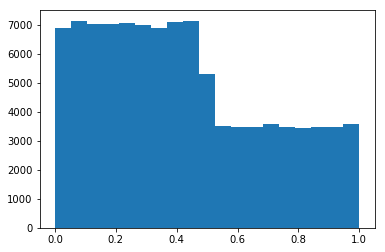

In [14]:
def make_events(average_number):
    num_events = np.random.poisson(lam=average_number)
    events = np.random.random(size=num_events) * 1.5
    mask = events < 1
    events[mask] = events[mask] * 0.5
    events[~mask] = events[~mask] - 0.5
    return events

plt.hist(make_events(100000), bins=np.linspace(0, 1, 20))
None

In [15]:
trials = 10000
cells = 10
coverage = 3

hit_rate_1 = []
hit_rate_2 = []
for _ in range(trials):
    events = make_events(10)
    if len(events) == 0:
        continue
    pred1 = coverage1(cells, coverage)
    pred2 = coverage2(cells, coverage)
    hit_rate_1.append( score(events, cells, pred1) )
    hit_rate_2.append( score(events, cells, pred2) )

pd.DataFrame({"One":hit_rate_1, "Two":hit_rate_2}).describe()

,One,Two
count,10000.000000,10000.000000
mean,0.302555,0.199724
std,0.160472,0.136016
min,0.000000,0.000000
25%,0.200000,0.100000
50%,0.294118,0.187500
75%,0.400000,0.285714
max,1.000000,1.000000


In [16]:
ratios = []

for _ in range(10000):
    events = make_events(10)
    log_ratio = likelihood1(events) - likelihood2(events)
    ratios.append(log_ratio)
    
pd.DataFrame(ratios).describe()

,0
count,10000.000000
mean,5.419622
std,3.777092
min,-3.657635
25%,2.688512
50%,4.904619
75%,7.595387
max,24.506569


In [17]:
one, two = [], []
for _ in range(10000):
    events = make_events(10)
    if len(events) == 0:
        continue
    one.append( likelihood1(events) / len(events) )
    two.append( likelihood2(events) / len(events) )
pd.DataFrame({"one":one, "two":two}).describe()

,one,two
count,9998.0,9998.000000
mean,0.0,-0.537126
std,0.0,0.354822
min,0.0,-2.881477
25%,0.0,-0.742671
50%,0.0,-0.500278
75%,0.0,-0.295465
max,0.0,0.440049


In [18]:
errors = []
for _ in range(10000):
    events = make_events(10)
    if len(events) < 2:
        continue
    kernel = scipy.stats.kde.gaussian_kde(events)
    e1, _ = scipy.integrate.quad(lambda x : (kernel(x) - func1(x))**2, 0, 1)
    e2, _ = scipy.integrate.quad(lambda x : (kernel(x) - func2(x))**2, 0, 1)
    errors.append((e1, e2))

In [19]:
pd.DataFrame({"one":[p[0] for p in errors], "two":[p[1] for p in errors]}).describe()

,one,two
count,9992.000000,9992.000000
mean,0.200730,0.762903
std,0.279527,0.461152
min,0.032237,0.054530
25%,0.076875,0.481650
50%,0.125253,0.669875
75%,0.229443,0.936467
max,10.078522,10.682809


# Finally...

Flip it about, now "ground truth" will be that events are twice as likely in $[1/2,1]$ as opposed to $[0,1/2]$.

Now hit rate favours model 2.  Likelihood favours (weakly) model 1.  KDE favours model 1.

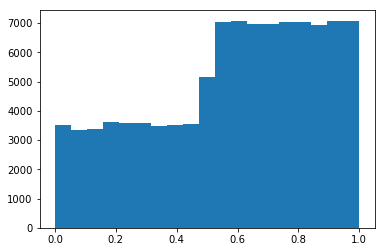

In [20]:
def make_events1(average_number):
    return 1 - make_events(average_number)

plt.hist(make_events1(100000), bins=np.linspace(0, 1, 20))
None

In [21]:
trials = 10000
cells = 10
coverage = 3

hit_rate_1 = []
hit_rate_2 = []
for _ in range(trials):
    events = make_events1(10)
    if len(events) == 0:
        continue
    pred1 = coverage1(cells, coverage)
    pred2 = coverage2(cells, coverage)
    hit_rate_1.append( score(events, cells, pred1) )
    hit_rate_2.append( score(events, cells, pred2) )

pd.DataFrame({"One":hit_rate_1, "Two":hit_rate_2}).describe()

,One,Two
count,9999.000000,9999.000000
mean,0.299005,0.401429
std,0.161717,0.163036
min,0.000000,0.000000
25%,0.181818,0.285714
50%,0.285714,0.400000
75%,0.400000,0.500000
max,1.000000,1.000000


In [22]:
ratios = []

for _ in range(10000):
    events = make_events1(10)
    log_ratio = likelihood1(events) - likelihood2(events)
    ratios.append(log_ratio)
    
pd.DataFrame(ratios).describe()

,0
count,10000.000000
mean,0.744658
std,2.803817
min,-7.572446
25%,-1.216704
50%,0.316195
75%,2.285786
max,18.178649


In [23]:
one, two = [], []
for _ in range(10000):
    events = make_events1(10)
    if len(events) == 0:
        continue
    one.append( likelihood1(events) / len(events) )
    two.append( likelihood2(events) / len(events) )
pd.DataFrame({"one":one, "two":two}).describe()

,one,two
count,10000.0,10000.000000
mean,0.0,-0.080728
std,0.0,0.301639
min,0.0,-2.402754
25%,0.0,-0.247010
50%,0.0,-0.038585
75%,0.0,0.133735
max,0.0,0.602009


In [24]:
errors = []
for _ in range(10000):
    events = make_events1(10)
    if len(events) < 2:
        continue
    kernel = scipy.stats.kde.gaussian_kde(events)
    e1, _ = scipy.integrate.quad(lambda x : (kernel(x) - func1(x))**2, 0, 1)
    e2, _ = scipy.integrate.quad(lambda x : (kernel(x) - func2(x))**2, 0, 1)
    errors.append((e1, e2))

In [26]:
pd.DataFrame({"one":[p[0] for p in errors], "two":[p[1] for p in errors]}).describe()

,one,two
count,9994.000000,9994.000000
mean,0.201497,0.303939
std,0.281399,0.268947
min,0.031006,0.037054
25%,0.076810,0.160567
50%,0.124121,0.251117
75%,0.226164,0.379557
max,13.151977,13.420936
